In [1]:
%%bash
hdfs dfs -ls / | tail -n 4
echo '*************************'
hdfs dfs -ls /vajhi
echo '*************************'
hdfs dfs -put Titanic_Dataset.csv /vajhi/
echo '*************************'
hdfs dfs -ls /vajhi
echo '*************************'

drwxr-xr-x   - rahimi          dmls          0 2025-12-20 13:30 /rahimi
drwxr-xr-x   - ramezani        dmls          0 2025-12-20 15:39 /ramezani
drwxr-xr-x   - soltanmohammadi dmls          0 2025-12-20 13:30 /soltanmohammadi
drwxr-xr-x   - vajhi           dmls          0 2025-12-26 14:20 /vajhi
*************************
Found 1 items
-rw-r--r--   1 vajhi dmls   52460705 2025-12-25 15:44 /vajhi/wiki_corpus
*************************
*************************
Found 2 items
-rw-r--r--   1 vajhi dmls      61194 2025-12-26 14:21 /vajhi/Titanic_Dataset.csv
-rw-r--r--   1 vajhi dmls   52460705 2025-12-25 15:44 /vajhi/wiki_corpus
*************************


In [2]:
from pyspark.sql import SparkSession
from IPython.display import display
import pyspark.sql.functions as f
import datetime
import numpy as np
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import feature
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt

%precision 3

'%.3f'

In [3]:
spark = SparkSession.builder \
    .appName("Titanic") \
    .master("spark://raspberrypi-dml0:7077") \
    .config("spark.cores.max", "16") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.memory", "5500m") \
    .config("spark.driver.memory", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .getOrCreate()
    
print(f"Master: {spark.sparkContext.master}")
print(f"App Name: {spark.sparkContext.appName}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Master: spark://raspberrypi-dml0:7077
App Name: Titanic


In [4]:
raw_data = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv('hdfs://raspberrypi-dml0:9000/vajhi/Titanic_Dataset.csv')
# raw_data = spark.read.text('Titanic_Dataset.csv')
raw_data.show(5,50)

+-----------+--------+------+--------------------------------------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                                              Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------------------------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|                           Braund, Mr. Owen Harris|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. John Bradley (Florence Briggs Tha...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|                            Heikkinen, Miss. Laina|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|      Futrelle, Mrs. Jacques Heath (Lily May Peel)|female|35.0|    1|    0|          113803|   53.1| 

In [5]:
raw_data.groupBy('Sex').avg('Survived').show()
raw_data.groupBy('Pclass').avg('Survived').show()
raw_data.groupBy('Survived').avg('Age').show()

+------+-------------------+
|   Sex|      avg(Survived)|
+------+-------------------+
|female| 0.7420382165605095|
|  male|0.18890814558058924|
+------+-------------------+



+------+-------------------+
|Pclass|      avg(Survived)|
+------+-------------------+
|     1| 0.6296296296296297|
|     3|0.24236252545824846|
|     2|0.47282608695652173|
+------+-------------------+



+--------+------------------+
|Survived|          avg(Age)|
+--------+------------------+
|       1|28.343689655172415|
|       0| 30.62617924528302|
+--------+------------------+



In [6]:
raw_data.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in raw_data.columns]).show()
raw_data.summary().show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



25/12/26 14:23:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|summary|      PassengerId|           Survived|            Pclass|                Name|   Sex|               Age|             SibSp|              Parch|            Ticket|             Fare|Cabin|Embarked|
+-------+-----------------+-------------------+------------------+--------------------+------+------------------+------------------+-------------------+------------------+-----------------+-----+--------+
|  count|              891|                891|               891|                 891|   891|               714|               891|                891|               891|              891|  204|     889|
|   mean|            446.0| 0.3838383838383838| 2.308641975308642|                NULL|  NULL| 29.69911764705882|0.5230078563411896|0.38159371492704824|260318.54916792738| 32.20420

In [7]:
raw_data.groupBy('Embarked').count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    NULL|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [8]:
raw_data = raw_data.fillna({
    'Embarked': 'S',
    'Age': 28
})

In [9]:
lg = LogisticRegression(featuresCol='Features', labelCol='Survived')
pipe = Pipeline(
    stages=[
        feature.StringIndexer(inputCol='Embarked',outputCol='Embarked_SI'),
        feature.OneHotEncoder(inputCol='Embarked_SI',outputCol='Embarked_OHE'),
        
        feature.StringIndexer(inputCol='Sex',outputCol='Sex_SI'),
        
        feature.VectorAssembler(
            inputCols=['Pclass', 'Sex_SI', 'Age', 'Fare', 'Embarked_OHE'],
            outputCol='features'
            ),
        lg
    ]
)

train, test = raw_data.randomSplit([0.8, 0.2])
model = pipe.fit(train)

In [10]:
test_predict = model.transform(test)
test_predict.select(['Survived', 'prediction']).show(5)

acc = MulticlassClassificationEvaluator(
    labelCol='Survived', predictionCol='prediction', metricName='accuracy'
    ).evaluate(test_predict)
print(f"accuracy: {acc:.4f}")

+--------+----------+
|Survived|prediction|
+--------+----------+
|       1|       1.0|
|       0|       0.0|
|       0|       1.0|
|       1|       1.0|
|       1|       1.0|
+--------+----------+
only showing top 5 rows


accuracy: 0.7812


In [11]:
with open('accuracy.txt', "w") as f:
    f.write(f'{acc}')

In [12]:
%%bash
hdfs dfs -put accuracy.txt /vajhi/
echo '*************************'
hdfs dfs -ls /vajhi
echo '*************************'

*************************
Found 3 items
-rw-r--r--   1 vajhi dmls      61194 2025-12-26 14:21 /vajhi/Titanic_Dataset.csv
-rw-r--r--   1 vajhi dmls          7 2025-12-26 14:24 /vajhi/accuracy.txt
-rw-r--r--   1 vajhi dmls   52460705 2025-12-25 15:44 /vajhi/wiki_corpus
*************************


/home/shared_files/spark/python/lib/pyspark.zip/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


Text(0.5, 1.0, 'Confusion Matrix - Titanic Logistic Regression')

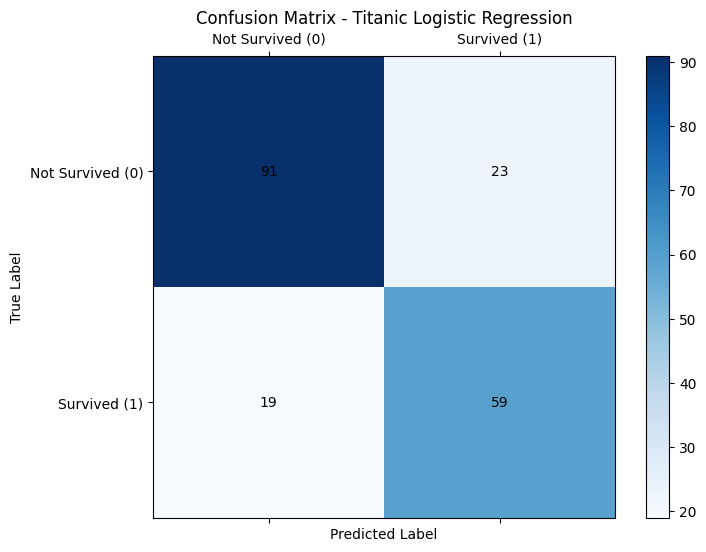

In [13]:
# https://gemini.google.com/share/3d60da2bca50
predictionAndLabels = test_predict.select("prediction", "Survived").rdd.map(lambda row: (float(row.prediction), float(row.Survived)))

metrics = MulticlassMetrics(predictionAndLabels)
confusion_matrix = metrics.confusionMatrix().toArray()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(confusion_matrix, cmap='Blues')
plt.colorbar(cax)

rows, cols = confusion_matrix.shape
for i in range(rows):
    for j in range(cols):
        ax.text(j, i, str(int(confusion_matrix[i, j])), ha='center', va='center', color='black')

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Not Survived (0)', 'Survived (1)'])
ax.set_yticklabels(['Not Survived (0)', 'Survived (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Titanic Logistic Regression')

In [14]:
spark.stop()